In [1]:
#=
using Pkg; 
packages = ["Knet", "AutoGrad", "Random", "Test", "MLDatasets", "CUDA", "Plots", "GR","Statistics",
            "IterTools", "StatsBase", "DSP", "Images", "DelimitedFiles", "MultivariateStats", "PyPlot", "PyCall"];
Pkg.add(packages);
=#

In [1]:
include("../src/modules/TUM69.jl")
include("../src/modules/Preprocess.jl")
include("../src/modules/Network.jl")
include("../src/modules/Utils.jl")

## Third party packages
using Knet: KnetArray, adam, relu, minibatch
using AutoGrad, Knet, CUDA


## Handwritten modules
using .TUM69: load_image_data   # Data reading
using .Preprocess: process_image # Preprocessing on the data
using .Network: GCN, train_summarize!, accuracy4, nll4, GenericMLP # Construction of custom network
using .Utils: notify

In [2]:
AutoGrad.set_gc_function(AutoGrad.default_gc)

default_gc (generic function with 1 method)

In [3]:
# Trick from Deniz Hoca to deal with this issue: https://github.com/denizyuret/Knet.jl/issues/524
#=
using Knet
function Knet.KnetArray(x::CuArray{T,N}) where {T,N}
    p = Base.bitcast(Knet.Cptr, pointer(x))
    k = Knet.KnetPtr(p, sizeof(x), Int(CUDA.device().handle), x)
    KnetArray{T,N}(k, size(x))
end
=#

In [4]:
# Array type setting for GPU usage
a_type() = (CUDA.functional() ? KnetArray{Float32} : Array{Float32})

a_type (generic function with 1 method)

In [5]:
# CUDA information
GC.gc(true)
CUDA.device()

LoadError: CUDA.jl did not successfully initialize, and is not usable.
If you did not see any other error message, try again in a new session
with the JULIA_DEBUG environment variable set to 'CUDA'.

In [6]:
path = CUDA.functional() ? "/userfiles/vaydingul20/data/new" : "./../data/trial" # path of the main data
DATA_PATH = isdir(path) && path

"./../data/trial"

In [10]:
X_train, y_train,
X_test, y_test, 
material_dict = @time load_image_data(DATA_PATH; mode = "baseline");  # Data loading routine

Train image data is being loaded!
Test image data is being loaded!
  2.738184 seconds (2.42 k allocations: 411.631 MiB)


In [11]:
println("X_train = ", summary(X_train))
println("y_train = ", summary(y_train))
println("X_test  = ", summary(X_test))
println("y_test  = ", summary(y_test))
println("material_dict = ", summary(material_dict))

X_train = 3-element Array{Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2},1}
y_train = 3-element Array{Int8,1}
X_test  = 3-element Array{Array{ColorTypes.RGB{FixedPointNumbers.Normed{UInt8,8}},2},1}
y_test  = 3-element Array{Int8,1}
material_dict = Dict{String,Int8} with 3 entries


In [12]:
#Preprocessing on the acceleration data
@time X_train_modified, y_train_modified = process_image(X_train, y_train);
@time X_test_modified, y_test_modified = process_image(X_test, y_test);

  2.526414 seconds (5.89 k allocations: 1.248 GiB, 17.28% gc time)
  1.905475 seconds (5.89 k allocations: 1.248 GiB, 2.76% gc time)


In [13]:
println("X_train = ", summary(X_train_modified))
println("y_train = ", summary(y_train_modified))
println("X_test  = ", summary(X_test_modified))
println("y_test  = ", summary(y_test_modified))
println("material_dict = ", summary(material_dict))

X_train = 384×384×3×144 Array{Float32,4}
y_train = 144-element Array{Int8,1}
X_test  = 384×384×3×144 Array{Float32,4}
y_test  = 144-element Array{Int8,1}
material_dict = Dict{String,Int8} with 3 entries


In [15]:
# Some constants that will be used in the network model
MINIBATCH_SIZE = 2
INPUT_SIZE = size(X_test_modified)[1:3]
OUTPUT_SIZE = size(collect(keys(material_dict)))[1];

In [16]:
# Minibatching
dtrn = minibatch(X_train_modified, y_train_modified, MINIBATCH_SIZE; xtype = a_type(), shuffle = true)
dtst = minibatch(X_test_modified, y_test_modified, MINIBATCH_SIZE; xtype = a_type(), shuffle = true);

In [17]:

model = GCN(INPUT_SIZE, OUTPUT_SIZE, 
       [(3, 3, 50 , relu, 0.0, (1, 1), (1, 1), (2, 2), true),
        (3, 3, 100, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (3, 3, 150, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (3, 3, 200, relu, 0.0, (1, 1), (1, 1), (2, 2), false),
        (4, 12,400, relu, 0.5, (1, 0), (1, 1), (1, 1), false),
        (1, 1, 250, relu, 0.5, (0, 0), (1, 1), (1, 1), false),
        (1, 1, OUTPUT_SIZE , relu, 0.5, (0, 0), (1, 1), (1, 1), false)
        ]; 
    hidden=[], optimizer_type = adam, lr = 1e-4, loss_fnc=nll4, accuracy_fnc = accuracy4, atype=a_type())



GCN((Main.Network.Conv(P(Array{Float32,4}(3,3,3,50)), P(Array{Float32,4}(1,1,50,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), true, Array{Float32,N} where N), Main.Network.Conv(P(Array{Float32,4}(3,3,50,100)), P(Array{Float32,4}(1,1,100,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), false, Array{Float32,N} where N), Main.Network.Conv(P(Array{Float32,4}(3,3,100,150)), P(Array{Float32,4}(1,1,150,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), false, Array{Float32,N} where N), Main.Network.Conv(P(Array{Float32,4}(3,3,150,200)), P(Array{Float32,4}(1,1,200,1)), Knet.Ops20.relu, 0, (1, 1), (1, 1), (2, 2), false, Array{Float32,N} where N), Main.Network.Conv(P(Array{Float32,4}(4,12,200,400)), P(Array{Float32,4}(1,1,400,1)), Knet.Ops20.relu, 0, (1, 0), (1, 1), (1, 1), false, Array{Float32,N} where N), Main.Network.Conv(P(Array{Float32,4}(1,1,400,250)), P(Array{Float32,4}(1,1,250,1)), Knet.Ops20.relu, 0, (0, 0), (1, 1), (1, 1), false, Array{Float32,N} where N), Main.Network.Conv(P(Array{Fl

┣███████████████████▉┫ [100.00%, 72/72, 10:57/10:57, 9.13s/i] 


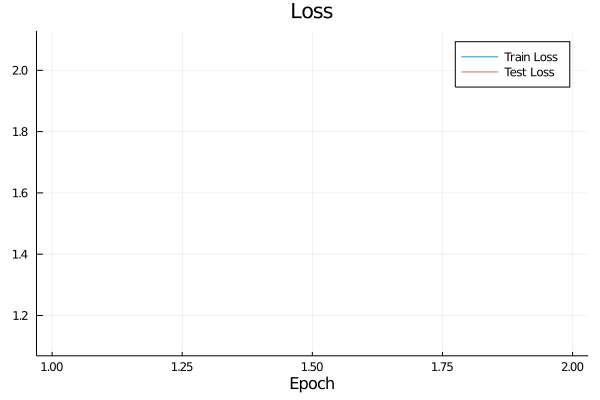

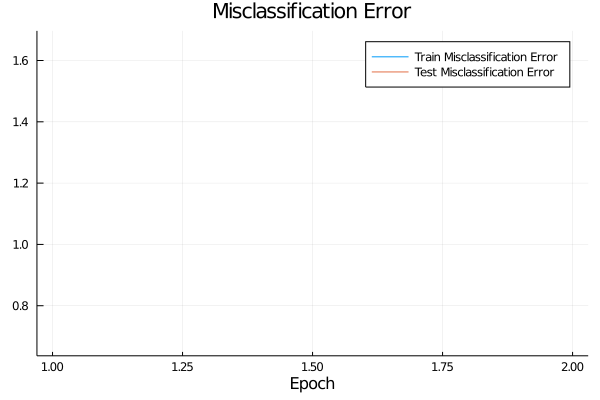

TRAINING PARAMETERS


Activation Function = relu
Optimizer Type = adam
Learning Rate = 0.0001
LAYERS:


Main.Network.Conv ==> W = (3, 3, 3, 50)   b = (1, 1, 50, 1)
Main.Network.Conv ==> W = (3, 3, 50, 100)   b = (1, 1, 100, 1)
Main.Network.Conv ==> W = (3, 3, 100, 150)   b = (1, 1, 150, 1)
Main.Network.Conv ==> W = (3, 3, 150, 200)   b = (1, 1, 200, 1)
Main.Network.Conv ==> W = (4, 12, 200, 400)   b = (1, 1, 400, 1)
Main.Network.Conv ==> W = (1, 1, 400, 250)   b = (1, 1, 250, 1)
Main.Network.Conv ==> W = (1, 1, 250, 3)   b = (1, 1, 3, 1)
In this network configuration,
there are total 4393253 parameters.
Final Loss
Train Loss = 1.0986124
Test Loss = 1.0986124


Final Misclassification Error
Train Misclassification Error = 0.6666667
Test Misclassification Error = 0.6666667


Test Accuracy = 0.3333333333333333


4×1 Array{Float32,2}:
 1.0986124
 1.0986124
 0.6666667
 0.6666667

In [19]:
# Training routine
# Currently, the model is not working due to the issue mentioned in: https://github.com/denizyuret/Knet.jl/issues/624#
# As soon as it is solved, I hope the model will be accurately working.
res = train_summarize!(model, dtrn, dtst; 
                       train_type = "epoch", progress_bar = true ,fig = true, info = true, 
                       epoch = 1, conv_epoch = 50, max_conv_cycle = 20)

In [ ]:
notify("OK!")